In [37]:
import matplotlib.pyplot as plt

import torch
import torchvision

import torch.optim as optim
from tqdm.auto import tqdm

from chest_xray_dcgan.data_setup import load_data

import numpy as np

from chest_xray_dcgan import engine, utils
from chest_xray_dcgan.model import Generator, Discriminator



In [38]:
normal_train_dir = "./data/train/train_normal"
normal_test_dir = "./data/test/test_normal"

gen_path = "./models/generator/g2.pth"
dis_path = "./models/discriminator/d2.pth"

batch_size = 256
num_workers = 2

normal_train_dataloader = load_data(normal_train_dir, batch_size, num_workers)
normal_test_dataloader = load_data(normal_test_dir, batch_size, num_workers)

In [39]:
gen = Generator()
dis = Discriminator()

utils.load_models(gen, dis, gen_path, dis_path)

(Generator(
   (main): Sequential(
     (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
     (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): ReLU(inplace=True)
     (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (13

In [40]:
gen.to("mps")
dis.to("mps")

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [41]:
loss_fn = torch.nn.BCELoss()

In [42]:
num_epochs = 0
beta1 = 0.5

gen_optimizer = optim.Adam(gen.parameters(), lr=0.00003, betas=(beta1, 0.999))
dis_optimizer = optim.Adam(dis.parameters(), lr=0.00003, betas=(beta1, 0.999))

In [43]:

for epoch in tqdm(range(num_epochs)):
    df, dr, gl = engine.train(gen, dis, normal_train_dataloader, loss_fn, dis_optimizer, gen_optimizer, "mps")
    print("df: " + str(df.cpu().item()))
    print("dr: " + str(dr.cpu().item()))
    print("gl: " + str(gl.cpu().item()))

0it [00:00, ?it/s]


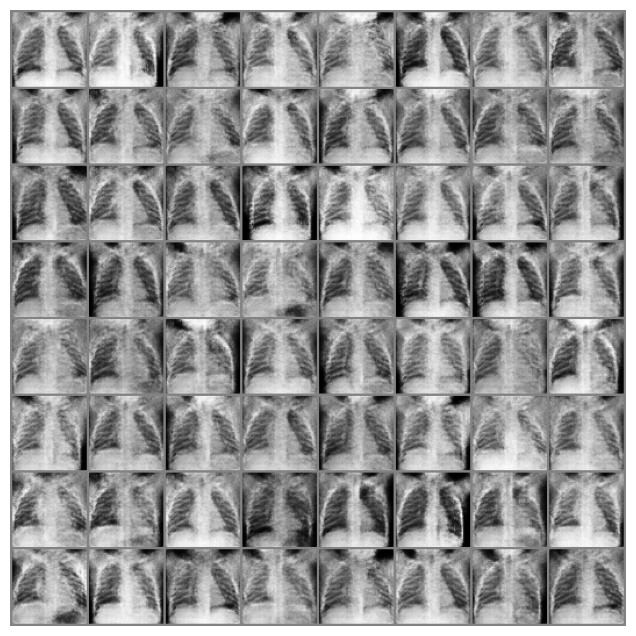

In [48]:
plt.figure(figsize=(8, 8))
plt.axis('off')
z = torch.randn(64, 128, 1, 1, device="mps")
plt.imshow(torchvision.utils.make_grid(gen(z).detach().cpu(), padding=2)[0], "gray")

In [45]:
image = next(iter(normal_train_dataloader))

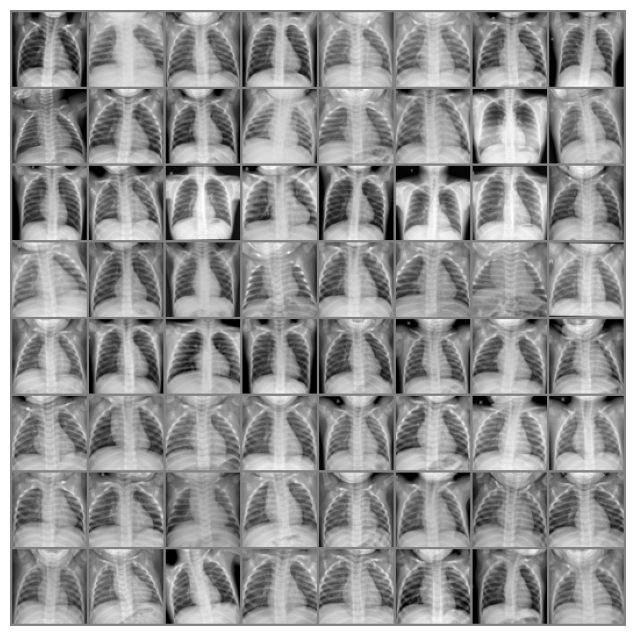

In [46]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(torchvision.utils.make_grid(image[0].cpu()[:64])[0], "gray")

In [47]:
# Uncomment and run cell to save model
#utils.save_models(gen, dis, gen_path, dis_path)